In [49]:
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet import Prophet
from fbprophet.serialize import model_to_json, model_from_json
from fbprophet.plot import plot_cross_validation_metric
import pandas as pd
import json
import os

In [87]:
def build_prophet(target, fname, features=None):
    # read file
    df = pd.read_feather(os.path.join('data', 'kaggle-preprocessed', f'{fname}.feather'))
    print(df.columns)

    # edit rainfall and temperature columns
    rainfall_columns = [col for col in df.columns if 'rainfall' in col]
    temperature_columns = [col for col in df.columns if 'temperature' in col]
    if rainfall_columns:
        df['rainfall'] = df[rainfall_columns].sum(axis=1) # sum rainfall because it can have high spatial variability
    if temperature_columns:
        df['temperature'] = df[temperature_columns].mean(axis=1) # mean temperature because spatial variability is normally smaller
    df.drop(columns=rainfall_columns, inplace=True)
    df.drop(columns=temperature_columns, inplace=True)

    # set the column names for prophet
    df.rename(columns={target: 'y', 'Date': 'ds'}, inplace=True)
    # 0 is nan in these files
    df = df[df['y'] != 0]
    # cannot handle nans for now assumed forward fill
    df.dropna(subset=['y'], inplace=True)
    df.interpolate(method='ffill', inplace=True)
    df.dropna(inplace=True)

    # set up prophet model
    model = Prophet(daily_seasonality=False) # no daily seasonality (because its daily data)

    # add rainfaill and temperature regressor
    if rainfall_columns:
        model.add_regressor('rainfall')
    if temperature_columns:
        model.add_regressor('temperature')

    # add other features if applicable
    if features:
        if features is 'all':
            feats = [col for col in df.columns if 'ds' not in col or 'y' not in col]
            for feat in feats:
                model.add_regressor(feat)
        else:
            for feat in features:
                model.add_regressor(feat)
    
    model.fit(df)
    df_cv = cross_validation(model, initial='3000 days', horizon='30 days', parallel='processes') # initial set to 3000 days to speed up

    with open(os.path.join('data', 'prophet-models', f'model_{fname}_{target}.json'), 'w') as fout:
        json.dump(model_to_json(model), fout)

    df_p = performance_metrics(df_cv, rolling_window=1)
    df_p.to_pickle(os.path.join('data', 'prophet-models', 'metrics', f'performance_metrics_{fname}_{target}.pckl'))

    # some plots
    fig = model.plot(df_cv)
    fig = plot_cross_validation_metric(df_cv, metric='mape')

    return df_p

# Aquifer

INFO:fbprophet:Making 118 forecasts with cutoffs between 2015-06-26 00:00:00 and 2020-05-31 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x184519f70>


horizon       mse      rmse       mae      mape     mdape  coverage
0 30 days  0.074426  0.272812  0.207388  0.038951  0.029926    0.7875

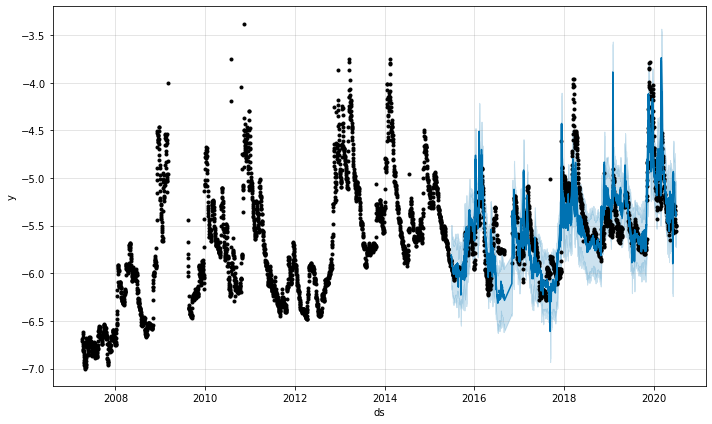

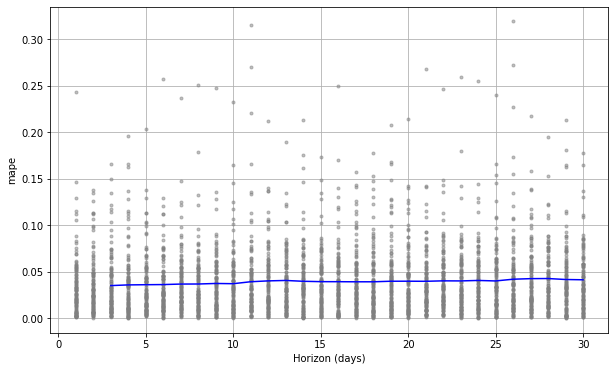

In [73]:
build_prophet(target='target_depth_to_groundwater_sal', fname='aquifer_auser', features=['hydrometry_monte_s_quirico', 'hydrometry_piaggione'])

INFO:fbprophet:Making 151 forecasts with cutoffs between 2014-04-03 00:00:00 and 2020-05-31 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x184f688e0>


horizon       mse      rmse       mae      mape     mdape  coverage
0 30 days  0.044629  0.211256  0.171658  0.013784  0.012411  0.403617

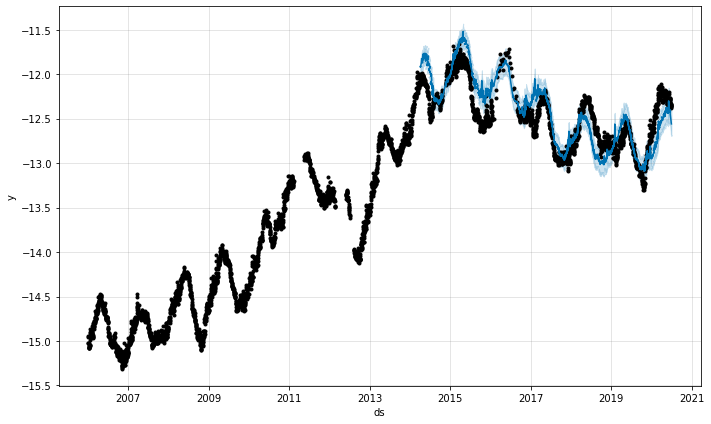

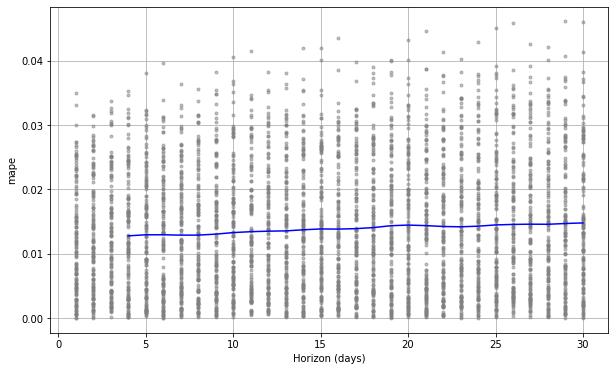

In [74]:
build_prophet(target='target_depth_to_groundwater_lt2', fname='aquifer_auser', features=['hydrometry_monte_s_quirico', 'hydrometry_piaggione'])

Index(['Date', 'rainfall_gallicano', 'rainfall_pontetetto',
       'rainfall_monte_serra', 'rainfall_orentano', 'rainfall_borgo_a_mozzano',
       'rainfall_piaggione', 'rainfall_calavorno', 'rainfall_croce_arcana',
       'rainfall_tereglio_coreglia_antelminelli',
       'rainfall_fabbriche_di_vallico', 'target_depth_to_groundwater_lt2',
       'target_depth_to_groundwater_sal', 'depth_to_groundwater_pag',
       'depth_to_groundwater_cos', 'depth_to_groundwater_diec',
       'temperature_orentano', 'temperature_monte_serra',
       'temperature_ponte_a_moriano', 'temperature_lucca_orto_botanico',
       'volume_pol', 'volume_cc1', 'volume_cc2', 'volume_csa', 'volume_csal',
       'hydrometry_monte_s_quirico', 'hydrometry_piaggione', 'year', 'month',
       'week', 'day', 'day_of_year', 'index_col'],
      dtype='object')


INFO:fbprophet:Making 140 forecasts with cutoffs between 2014-09-15 00:00:00 and 2020-05-31 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x184e7aa00>


horizon       mse      rmse       mae      mape    mdape  coverage
0 30 days  0.431918  0.657205  0.552352  0.094773  0.08644  0.566283

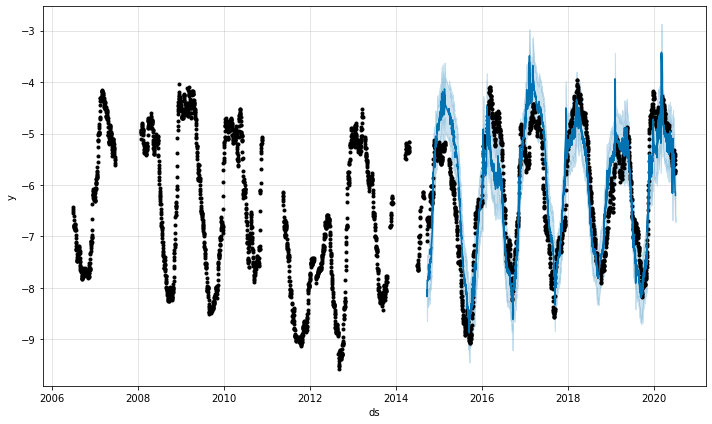

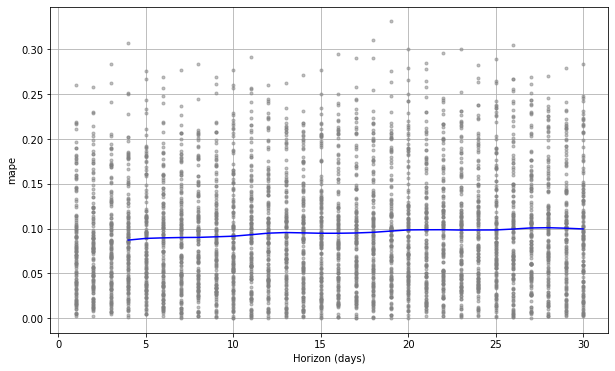

In [78]:
build_prophet(target='depth_to_groundwater_cos', fname='aquifer_auser', features=['hydrometry_monte_s_quirico', 'hydrometry_piaggione'])

# Lake

Index(['Date', 'rainfall_s_piero', 'rainfall_mangona', 'rainfall_s_agata',
       'rainfall_cavallina', 'rainfall_le_croci', 'temperature_le_croci',
       'target_lake_level', 'target_flow_rate', 'year', 'month', 'week', 'day',
       'day_of_year', 'index_col'],
      dtype='object')


INFO:fbprophet:Making 200 forecasts with cutoffs between 2012-03-29 00:00:00 and 2020-05-31 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x184e8fe50>


horizon       mse      rmse       mae      mape     mdape  coverage
0 30 days  3.005288  1.733577  1.158094  0.004646  0.002745     0.624

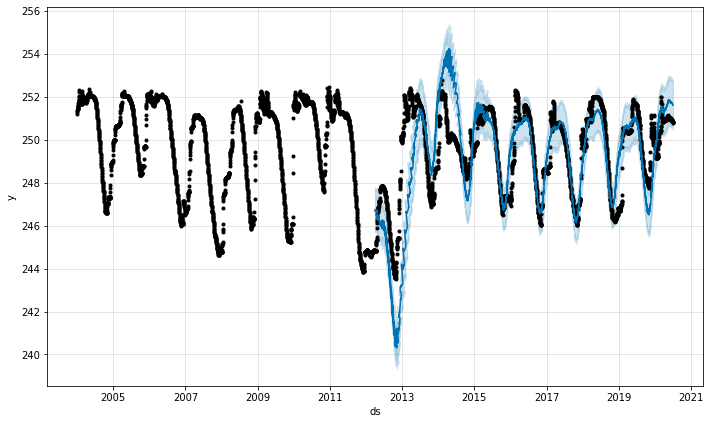

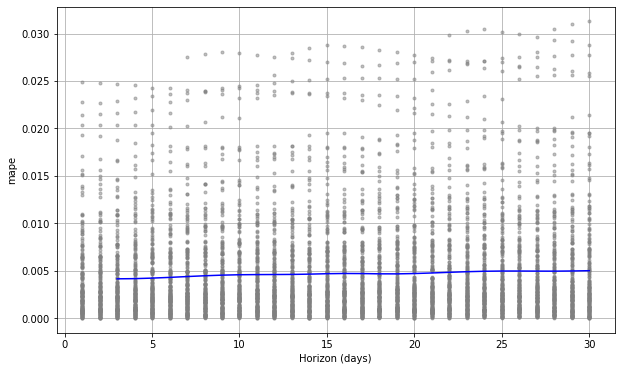

In [81]:
build_prophet(target='target_lake_level', fname='lake_bilancino')

In [82]:
build_prophet(target='target_flow_rate', fname='lake_bilancino')

Index(['Date', 'rainfall_s_piero', 'rainfall_mangona', 'rainfall_s_agata',
       'rainfall_cavallina', 'rainfall_le_croci', 'temperature_le_croci',
       'target_lake_level', 'target_flow_rate', 'year', 'month', 'week', 'day',
       'day_of_year', 'index_col'],
      dtype='object')


INFO:fbprophet:Making 200 forecasts with cutoffs between 2012-03-29 00:00:00 and 2020-05-31 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x184e5e580>


KeyboardInterrupt: 

# River

In [84]:
build_prophet(target='target_hydrometry_nave_di_rosano', fname='river_arno')

Index(['Date', 'rainfall_le_croci', 'rainfall_cavallina', 'rainfall_s_agata',
       'rainfall_mangona', 'rainfall_s_piero', 'rainfall_vernio',
       'rainfall_stia', 'rainfall_consuma', 'rainfall_incisa',
       'rainfall_montevarchi', 'rainfall_s_savino', 'rainfall_laterina',
       'rainfall_bibbiena', 'rainfall_camaldoli', 'temperature_firenze',
       'target_hydrometry_nave_di_rosano', 'year', 'month', 'week', 'day',
       'day_of_year', 'index_col'],
      dtype='object')


INFO:fbprophet:Making 280 forecasts with cutoffs between 2008-12-15 00:00:00 and 2020-05-31 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x18588b100>


KeyboardInterrupt: 

# Water spring

In [88]:
build_prophet(target='flow_rate_lupa', fname='water_spring_lupa')

Index(['Date', 'rainfall_terni', 'flow_rate_lupa', 'year', 'month', 'week',
       'day', 'day_of_year', 'index_col'],
      dtype='object')


ValueError: Regressor 'temperature' missing from dataframe